<a href="https://colab.research.google.com/github/240609/MLF/blob/main/Project/Kopie_se%C5%A1itu_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJEKT**

#0. Import needed libraries

In [86]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. data preprocesing
## 1.1 Importing data

In [ ]:
train_data = pd.read_csv('label_train.csv')
test_data = pd.read_csv('test_format.csv')

In [ ]:
print(os.listdir('/content/drive/MyDrive/MLF'))


['test_format.csv', 'label_train.csv', 'Train', 'Test']


In [ ]:
# Set the path to your data
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/MLF'


# Load the CSV files
label_train = pd.read_csv(os.path.join(data_path, 'label_train.csv'))
test_format = pd.read_csv(os.path.join(data_path, 'test_format.csv'))

# Load all NPY files from the Train directory
train_data = []
for i in range(1491):  # Assuming files are named from 0.npy to 1490.npy
    file_path = os.path.join(data_path, 'Train', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        train_data.append(data)

# Convert list to a NumPy array
train_data = np.array(train_data)

# Load all NPY files from the Test directory
test_data = []
for i in range(120):  # Assuming files are named from 0.npy to 119.npy
    file_path = os.path.join(data_path, 'Test', f'{i}.npy')
    if os.path.exists(file_path):
        data = np.load(file_path)
        test_data.append(data)

# Convert list to a NumPy array
test_data = np.array(test_data)

# Display the shapes of the loaded data
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train data shape: (1491, 72, 48)
Test data shape: (120, 72, 48)


In [ ]:
print(train_data[0])
print(test_data[0])
print(label_train.iloc[1490])
print(test_format.iloc[119])

[[-0.00066049 -0.00052595 -0.00047199 ... -0.00066865 -0.00048514
  -0.00070618]
 [-0.00064383 -0.00053528 -0.00063444 ... -0.00067458 -0.00046934
  -0.00065118]
 [-0.00067932 -0.00047187 -0.00071757 ... -0.00048743 -0.00054504
  -0.00081401]
 ...
 [-0.00083519 -0.00053305 -0.00052366 ... -0.00067314 -0.00034153
  -0.00050774]
 [-0.00088075 -0.00034513 -0.00061526 ... -0.00054536 -0.00050744
  -0.00062426]
 [-0.00075779 -0.00049551 -0.00049004 ... -0.00048165 -0.00056859
  -0.00055842]]
[[-1.7305878e-04 -4.8972369e-04 -3.4880164e-04 ... -3.4640208e-04
  -5.0616899e-04 -4.5606252e-04]
 [-3.3218710e-04 -5.8344856e-04 -2.9980805e-04 ... -3.7729673e-04
  -3.9854753e-04 -5.1197334e-04]
 [-1.9570411e-04 -2.9922460e-04 -3.7303672e-04 ... -3.7766932e-04
  -4.1066998e-04 -5.3191831e-04]
 ...
 [-3.2046885e-04 -3.1028499e-04 -4.2862806e-04 ... -2.0776529e-04
  -3.5671541e-04 -4.7033376e-04]
 [ 7.9174515e-06 -3.3841381e-04 -2.7957352e-04 ... -3.1606591e-04
  -4.3772094e-04 -4.0889636e-04]
 [-2.993

##1.2 Preprocesing data

In [ ]:
y_train = label_train["target"].values  # Extrahujeme správný sloupec
y_test = test_format["target"].values   # Testovací štítky

In [ ]:
# Přetvarujeme data tak, aby každý vzorek byl jedním řádkem (3456 = 72*48)
X_train_reshaped = train_data.reshape(train_data.shape[0], -1)
X_test_reshaped = test_data.reshape(test_data.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Vracíme data zpět do původního 2D tvaru
X_train_scaled = X_train_scaled.reshape(train_data.shape)
X_test_scaled = X_test_scaled.reshape(test_data.shape)

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)


(1491, 3456)
(120, 3456)
(1491, 72, 48)
(120, 72, 48)


In [ ]:
X_train_final = X_train_scaled[..., np.newaxis]  # tvar (1491, 72, 48, 1)
X_test_final = X_test_scaled[..., np.newaxis]

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

print(y_train_encoded.shape)
print(y_test_encoded.shape)
print(y_train_encoded[10:20])
print(y_test_encoded[50:60])

(1491, 3)
(120, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


#2. Model Selection and Implementation

In [ ]:
# Vytvoření modelu pomocí sekvenční architektury
model = Sequential()

# Vstupní vrstva: očekáváme vstupy ve tvaru (72, 48, 1)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Další konvoluční blok
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Třetí konvoluční blok
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Převedení 2D map na 1D vektor
model.add(Flatten())
model.add(Dropout(0.5))

# Skrytá (dense) vrstva
model.add(Dense(128, activation='relu'))

# Výstupní vrstva pro 3 třídy se softmax aktivací
model.add(Dense(3, activation='softmax'))

# Kompilace modelu s optimalizátorem Adam a categorical crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Shrnutí modelu pro kontrolu architektury
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 70, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 33, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,835 (2.11 MB)

 Trainable params: 552,387 (2.11 MB)

 Non-trainable params: 448 (1.75 KB)

#3. Model Training

In [ ]:
history = model.fit(X_train_final, y_train_encoded,
                    validation_data=(X_test_final, y_test_encoded),
                    epochs=20,
                    batch_size=32)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.7916 - loss: 1.4296 - val_accuracy: 0.0000e+00 - val_loss: 50.6241
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9885 - loss: 0.0596 - val_accuracy: 0.0000e+00 - val_loss: 107.0119
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9959 - loss: 0.0169 - val_accuracy: 0.0000e+00 - val_loss: 126.0049
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9963 - loss: 0.0117 - val_accuracy: 0.0000e+00 - val_loss: 131.4632
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0032 - val_accuracy: 0.0000e+00 - val_loss: 124.1435
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0098 - val_accuracy: 0.0000e+00 - val_loss: 112.8330
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.0000e+00 - val_loss: 95.4998
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss:

#4. Model Evaluation

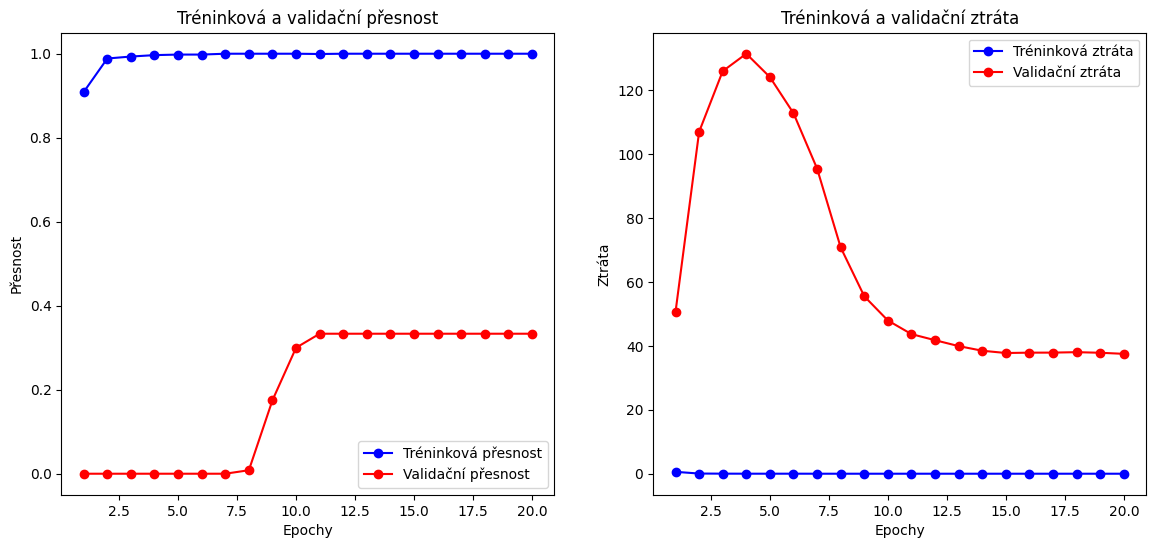

In [ ]:
# Získání metrik z objektu history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Počet epoch
epochs = range(1, len(acc) + 1)

# Vykreslení přesnosti
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Tréninková přesnost')
plt.plot(epochs, val_acc, 'ro-', label='Validační přesnost')
plt.title('Tréninková a validační přesnost')
plt.xlabel('Epochy')
plt.ylabel('Přesnost')
plt.legend()

# Vykreslení ztráty
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Tréninková ztráta')
plt.plot(epochs, val_loss, 'ro-', label='Validační ztráta')
plt.title('Tréninková a validační ztráta')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.legend()

plt.show()

#5. Hyperparameter Tuning

#6. Conclusion

